In [1]:
import sys
import random
from configparser import ConfigParser

config = ConfigParser()
config.read("config.ini")
CARLA_PATH = config.get("main", "CARLA_PATH")
# Enable import of 'carla'
sys.path.append(CARLA_PATH + "PythonAPI/carla/dist/carla-0.9.9-py3.6-linux-x86_64.egg")
# Enable import of 'agents' and it's submodules
sys.path.insert(0, CARLA_PATH + "PythonAPI/carla/")
# Enable import of utilities from GlobalPathPlanner
sys.path.insert(0, "../../../global_route_planner/")

import carla
from agents.navigation.behavior_agent import BehaviorAgent
from agents.navigation.local_planner import LocalPlanner, _compute_connection
from global_planner import get_client, spawn_vehicle, draw_waypoints, get_global_planner
import numpy as np 
from shapely.geometry import MultiLineString

from cartesian_to_frenet import get_frenet_from_cartesian, get_path_linestring

In [2]:
##### (-88.2855453491211, 67.1432876586914, 0.8242672681808472, 91.43128967285156)

In [3]:
def get_turn_direction(vector_current, vector_next):
    
    vector_current = np.array([vector_current.x, vector_current.y])
    vector_next = np.array([vector_next.x, vector_next.y])

    cos_theta = np.dot(vector_current, vector_next) / (np.linalg.norm(vector_current)*np.linalg.norm(vector_next) + 1e-5)
#     angle_rad = np.arccos(cos_theta)
    
    cross_product = np.cross(vector_current, vector_next)
    
    sin_theta = cross_product / (np.linalg.norm(vector_current)*np.linalg.norm(vector_next) + 1e-5)
#     direction = np.sign(cross_product)
    
    angle_rad = np.arcsin(sin_theta)
    
    return np.rad2deg(angle_rad)


def filter_close_waypoints_on_junction(pairs_of_waypoints_on_jn, thresh = 5):
    
    output_list = []
    
    for pair in pairs_of_waypoints_on_jn:
        
        location1 = pair[0].transform.location
        location2 = pair[1].transform.location
        
        location1 = np.array([location1.x, location1.y])
        location2 = np.array([location2.x, location2.y])
        
        if np.linalg.norm(location1-location2) > thresh:
            output_list.append(pair)
            
    return output_list

    
    

### Initialize client, CARLA world, and a global route planner

In [4]:
# Get client to interact with CARLA server
client = get_client()

# Get current CARLA world
world = client.get_world()

# Get global planner
grp = get_global_planner(world, 1)  ## Discretization of 1

Connection to CARLA server established!


### Find Traffic Lights

In [5]:
traffic_light_list = world.get_actors().filter('traffic.traffic_light*')

### Spawn a vehicle

In [36]:
actor.destroy()
actor = spawn_vehicle(world, "model3")
actor_waypoint = world.get_map().get_waypoint(actor.get_location(),project_to_road=True)
draw_waypoints(world, [actor_waypoint], 10)

### Attach a behavior agent to the vehicle

In [37]:
agent = BehaviorAgent(actor)

### Finding the point on ego lane at the next junction

In [38]:
points_on_actor_lane = actor_waypoint.next_until_lane_end(1)
last_point_on_lane = points_on_actor_lane[-1]

connections_to_last_point_on_lane = last_point_on_lane.next(1)

connecting_roads = []
for point in connections_to_last_point_on_lane:
    connecting_roads.append(point.next_until_lane_end(1))



### Get the junction object

In [39]:
junction = connections_to_last_point_on_lane[0].get_junction()
pairs_of_waypoints_on_jn = junction.get_waypoints(carla.LaneType.Driving)
pairs_of_waypoints_on_jn = [(pair[0].previous(1)[0],pair[1].next(1)[0]) for pair in pairs_of_waypoints_on_jn]
filtered_pairs_of_waypoints_on_jn = filter_close_waypoints_on_junction(pairs_of_waypoints_on_jn)
print("Length of the list of pairs:", len(filtered_pairs_of_waypoints_on_jn))

Length of the list of pairs: 14


In [52]:
for idx in range(len(filtered_pairs_of_waypoints_on_jn)):
# idx = 2
    draw_waypoints(world, filtered_pairs_of_waypoints_on_jn[idx], 10)
    print(filtered_pairs_of_waypoints_on_jn[idx][0].road_id, filtered_pairs_of_waypoints_on_jn[idx][1].road_id)
    print("Angle difference:",get_turn_direction(filtered_pairs_of_waypoints_on_jn[idx][0].transform.rotation.get_forward_vector(), filtered_pairs_of_waypoints_on_jn[idx][1].transform.rotation.get_forward_vector()))


24 78
Angle difference: 88.88563608814091
78 24
Angle difference: -88.88563441335036
25 78
Angle difference: -88.88563619197454
78 4
Angle difference: 0.056044333842212024
4 24
Angle difference: 88.83103779790476
24 4
Angle difference: -88.83101946949523
25 4
Angle difference: 88.83101957359301
4 25
Angle difference: -88.83103769940884
78 4
Angle difference: 0.056044333842212024
4 78
Angle difference: -0.056027475543410095
4 78
Angle difference: -0.05602747956948066
24 25
Angle difference: 0.0
25 24
Angle difference: 0.0
78 25
Angle difference: 88.88563430951625


In [31]:
draw_waypoints(world, filtered_pairs_of_waypoints_on_jn[3][0].previous_until_lane_start(1),10)

### Get previous waypoints from all entry junction waypoints, and next from all exit junction waypoints

In [41]:
waypoints = []

lanes_in_junction = {}

for pair in filtered_pairs_of_waypoints_on_jn:
    waypoints.append(pair[0].previous(1)[0])
    waypoints.append(pair[1].next(1)[0])
    
    ## Waypoint coming into the junction
    road_id = pair[0].road_id
    lane_id = pair[0].lane_id
    
    if (road_id, lane_id) in lanes_in_junction:
        lanes_in_junction[(road_id, lane_id)].append((pair[0],0))
    else:
        lanes_in_junction[(road_id, lane_id)] = [(pair[0],0)]
        
    ## Waypoint coming out of the junction
    
    road_id = pair[1].road_id
    lane_id = pair[1].lane_id
    
    if (road_id, lane_id) in lanes_in_junction:
        lanes_in_junction[(road_id, lane_id)].append((pair[1],1))
    else:
        lanes_in_junction[(road_id, lane_id)] = [(pair[1],1)]
        
    
# # waypoints = list(set(waypoints))

## Removing intermediate points

keys = list(lanes_in_junction.keys())
for key in keys:
    ins_and_outs = list(set([pair[1] for pair in lanes_in_junction[key]]))
    if len(ins_and_outs) == 2:
        lanes_in_junction.pop(key, "None")
        
    
for key in lanes_in_junction.keys():
    lanes_in_junction[key] = lanes_in_junction[key][0]


In [42]:
lanes_in_junction

{(4, -2): (<carla.libcarla.Waypoint at 0x7f0200554920>, 0),
 (4, -1): (<carla.libcarla.Waypoint at 0x7f02005552f0>, 0),
 (4, 2): (<carla.libcarla.Waypoint at 0x7f0200554c38>, 1),
 (4, 3): (<carla.libcarla.Waypoint at 0x7f0200554608>, 1),
 (24, -1): (<carla.libcarla.Waypoint at 0x7f02005b6348>, 0),
 (24, 1): (<carla.libcarla.Waypoint at 0x7f020054bce8>, 1),
 (25, -1): (<carla.libcarla.Waypoint at 0x7f0200555348>, 1),
 (25, 1): (<carla.libcarla.Waypoint at 0x7f020054bf50>, 0),
 (78, -2): (<carla.libcarla.Waypoint at 0x7f02005545b0>, 0),
 (78, -1): (<carla.libcarla.Waypoint at 0x7f020054bc90>, 0),
 (78, 2): (<carla.libcarla.Waypoint at 0x7f020054bfa8>, 1),
 (78, 3): (<carla.libcarla.Waypoint at 0x7f02005b63a0>, 1)}

In [23]:
draw_waypoints(world, [lanes_in_junction[key][0] for key in lanes_in_junction.keys()])

In [157]:
# road_lane_id_pairs = []
# for wp in waypoints:
#     road_lane_id_pairs.append((wp.road_id, wp.lane_id))
# road_lane_id_pairs = list(set(road_lane_id_pairs))

In [48]:
for i in range(1,len(waypoints),2):
    draw_waypoints(world,waypoints[i].next_until_lane_end(1)[:40],10)
    
for i in range(0,len(waypoints),2):
    draw_waypoints(world,waypoints[i].previous_until_lane_start(1)[:40],10)

### Identifying perpendicular and parallel roads

In [49]:
## Get the end waypoint 
end_wp = last_point_on_lane
ego_road_id = end_wp.road_id

perpendicular_roads = []
parallel_roads = []

## Get angle with each waypoint on the junction
angle_road_id_pairs = []
for i,waypoint_on_junction in enumerate(waypoints):
    angle = get_turn_direction(end_wp.transform.rotation.get_forward_vector(), waypoint_on_junction.transform.rotation.get_forward_vector())
    road_id = waypoint_on_junction.road_id

    if(i%2 == 0):
        next_points_on_lane = waypoint_on_junction.previous_until_lane_start(1)[:20]
        linestring = get_path_linestring(next_points_on_lane)
    else:
        next_points_on_lane = waypoint_on_junction.next_until_lane_end(1)[:20]
        linestring = get_path_linestring(next_points_on_lane)
        
    if abs(angle) <= 30:
        parallel_roads.append(linestring)
    else:
        perpendicular_roads.append(linestring)

    
    
        
    angle_road_id_pairs.append((angle,road_id))
    


# for pair in angle_road_id_pairs:
#     if pair[0] > 0 and pair [0] > 30:
#         perpendicular_roads.append(pair[1])
#     elif abs(pair[0]) <= 30:
#         parallel_roads.append(pair[1])
#     else:
#         perpendicular_roads.append(pair[1])

# parallel_roads = list(set(parallel_roads))
# perpendicular_roads = list(set(perpendicular_roads))

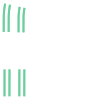

In [56]:
aa = MultiLineString(perpendicular_roads)


In [72]:
bb = MultiLineString(parallel_roads)

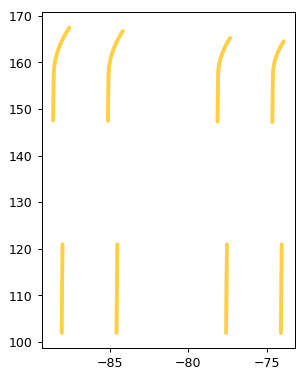

In [71]:

from math import sqrt

GM = (sqrt(5)-1.0)/2.0
W = 8.0
H = W*GM
SIZE = (W, H)

BLUE = '#6699cc'
GRAY = '#999999'
DARKGRAY = '#333333'
YELLOW = '#ffcc33'
GREEN = '#339933'
RED = '#ff3333'
BLACK = '#000000'

COLOR_ISVALID = {
    True: BLUE,
    False: RED,
}

def plot_line(ax, ob, color=GRAY, zorder=1, linewidth=3, alpha=1):
    x, y = ob.xy
    ax.plot(x, y, color=color, linewidth=linewidth, solid_capstyle='round', zorder=zorder, alpha=alpha)
    
def plot_lines(ax, ob):
    color = color_issimple(ob)
    for line in ob:
        plot_line(ax, line, color=color, alpha=0.7, zorder=2)
        
def color_issimple(ob, simple=BLUE, complex=YELLOW):
    if ob.is_simple:
        return simple
    else:
        return complex

fig = plt.figure(1, figsize=SIZE, dpi=90)

# 1: disconnected multilinestring
ax = fig.add_subplot(121)

plot_lines(ax, aa)


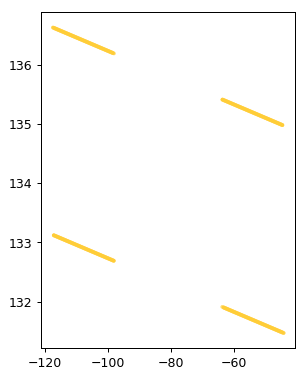

In [73]:
fig = plt.figure(1, figsize=SIZE, dpi=90)

# 1: disconnected multilinestring
ax = fig.add_subplot(121)

plot_lines(ax, bb)

In [53]:
parallel_roads

### Fitting lines 

In [ ]:

for i in range(0,len(waypoints),2):

    current_road_waypoints = 